# Swing-amplification spiral ODE-solver

## Problem
Swing-amplification as a spiral-arm formation mechanism makes predictions about the shape of spiral arms (at least using linear density wave theory).
Can we test those predictions against 

## Method
Assume the galaxy has a flat roation curve. The equation for a flat rotation curve is
$$\Omega = \frac{a}{2\pi r}\tanh{br}.$$

Thus the rotational shear of a flat rotation curve is given by
$$\Gamma = -\frac{d\log\Omega}{d\log{r}} = -r\frac{d\ln\Omega}{dr} = 1 - \frac{4 b r e^{2br}}{e^{4br} - 1}.$$

Swing-amplification predicts that the spiral arm's pitch angle $\phi$ is approximately
$$\tan\phi \approx \frac{2}{7}\frac{\sqrt{4 - 2\Gamma}}{\Gamma}.$$

Combining this with the definition of pitch angle (note that constant $\phi$ results in log spiral $r=ae^{\theta\tan{\phi}}$) gives
$$\frac{r'}{r} = \tan\phi \approx \frac{2}{7}\frac{\sqrt{4 - 2\Gamma}}{\Gamma}.$$

Define $R := 2br$, we then have that
$$\Gamma = 1 - \frac{2 R e^{R}}{e^{R} - 1} = 1 - \frac{R}{\sinh{R}}.$$
$$\frac{\mathrm{d}R}{\mathrm{d}\theta} = R' = \frac{2\sqrt{2}}{7}R\frac{\sqrt{1 + \frac{R}{\sinh{R}}}}{1 - \frac{R}{\sinh{R}}}.$$

Given 
$$\frac{\mathrm{d}R}{\mathrm{d}\theta} = \frac{\mathrm{d}R}{\mathrm{d}r}\frac{\mathrm{d}r}{\mathrm{d}\theta} = 2br',$$

We obtain the differential equation
$$r' = \frac{2\sqrt{2}}{7}r\frac{\sqrt{1 + \frac{2br}{\sinh{2br}}}}{1 - \frac{2br}{\sinh{2br}}}.$$


In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from scipy import optimize
from IPython.display import display
from numba import jit
from gzbuilderspirals import fitting
from gzbuilderspirals import xy_from_r_theta

In [2]:
plt.style.use('seaborn')

In [3]:
N = 500
theta = np.linspace(1, 2* np.pi, N)

@jit(nopython=True)
def dydt(r, theta, b):
    R = 2 * b * r
    s = np.sinh(R)
    return (
        2*np.sqrt(2) / 7 * r
        * np.sqrt(1 + R / s) / (1 - R / s)
    )
# call to trigger a numba compilation (use odeint to ensure 
# consistent function signature)
%timeit _ = odeint(dydt, 1, theta, args=(1,))[:, 0]

263 µs ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


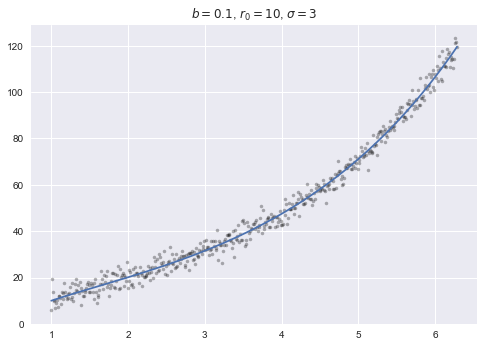

In [4]:
true_b = 0.1
true_r0 = 10
true_sigma = 3
y = odeint(dydt, true_r0, theta, args=(true_b,))[:, 0]
noise = np.random.normal(size=theta.size, scale=true_sigma)
y_obs = y + noise
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0')
plt.title(r'$b = {}$, $r_0 = {}$, $\sigma = {}$'.format(true_b, true_r0, true_sigma));

This is a difficult-to-solve problem, as combinations of parameters very different from the true values can create realistic outputs, for example:

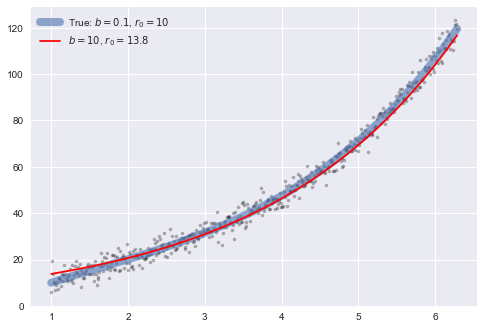

In [5]:
bad_b = 10
bad_r0 = 13.8
bad_y = odeint(dydt, bad_r0, theta, args=(bad_b,))[:, 0]
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0', linewidth=8, alpha=0.6, label='True: $b = {}$, $r_0 = {}$'.format(true_b, true_r0))
plt.plot(theta, bad_y, 'r', label='$b = {}$, $r_0 = {}$'.format(bad_b, bad_r0))
plt.legend();

A log spiral would also be an acceptable profile!

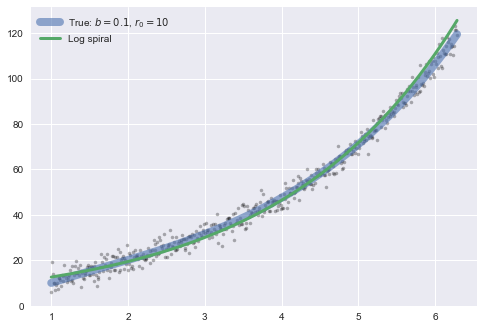

In [6]:
logsp_model = fitting.get_log_spiral_pipeline()
logsp_model.fit(theta[y_obs > 0].reshape(-1, 1), y_obs[y_obs > 0])
t_predict = np.linspace(min(theta), max(theta), 500)
y_logsp = logsp_model.predict(t_predict.reshape(-1, 1))
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0', linewidth=8, alpha=0.6, label='True: $b = {}$, $r_0 = {}$'.format(true_b, true_r0))
plt.plot(t_predict, y_logsp, 'C1', linewidth=3, label='Log spiral')
plt.legend();

Let's get some sensible starting guesses, optimize the absolute error of the odeint

Guesses from regression:
	b: 0.1019, r_0: 10.3983, sigma: 2.9405
Errors on guesses:
	b: 1.95%, r_0: 3.98%, sigma: 1.98%


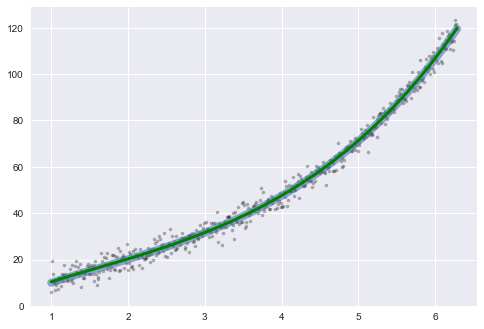

In [7]:
def f(p):
    # p = (b, r0)
    y = odeint(dydt, p[1], theta, args=(p[0],))[:, 0]
    return np.abs(y - y_obs).sum()

res = optimize.minimize(f, (0.1, 0.1))
guess_b, guess_r0 = res['x']
y_guess = odeint(dydt, guess_r0, theta, args=(guess_b,))[:, 0]
guess_sigma = (y_obs - y_guess).std()
print('Guesses from regression:')
print('\tb: {:.4f}, r_0: {:.4f}, sigma: {:.4f}'.format(
    guess_b, guess_r0, guess_sigma
))
print('Errors on guesses:')
print('\tb: {:.2%}, r_0: {:.2%}, sigma: {:.2%}'.format(
    abs(true_b - guess_b) / true_b,
  abs(true_r0 - guess_r0) / true_r0,
  abs(true_sigma - guess_sigma) / true_sigma
))
plt.plot(theta, y_obs, 'k.', alpha=0.3)
plt.plot(theta, y, 'C0', linewidth=8, alpha=0.6)
plt.plot(theta, y_guess, 'g', linewidth=3);

Okay, that's a pretty good starting point! Compare the possible fits using their r2 score:

In [8]:
from sklearn.metrics import r2_score
print('{:<30} {:.4f}'.format('True value:', r2_score(y_obs, y)))
print('{:<30} {:.4f}'.format('Swing amplified spiral:', r2_score(y_obs, y_guess)))
print('{:<30} {:.4f}'.format('Bad swing amplified spiral:', r2_score(y_obs, bad_y)))
print('{:<30} {:.4f}'.format('Log spiral:', r2_score(y_obs, y_logsp)))

True value:                    0.9905
Swing amplified spiral:        0.9905
Bad swing amplified spiral:    0.9875
Log spiral:                    0.9868


It's a pretty close race...

## Monte Carlo solving

Let's feed this into a `pymc3` solver which makes use of the RK4 algorithm coded in theano (thanks Coleman!).

Priors can be seen in the diagram below. All distributions have their test value set to the result from the fit. 

In [9]:
C = 2 * np.sqrt(2) / 7

def theano_dydt(r, theta, b):
    R = 2 * b * r
    s = tt.sinh(R)
    return C * r * tt.sqrt(1 + R / s) / (1 - R / s)

def theano_rk4(t, t_m1, y, *args):
    dt = t - t_m1
    k1 = dt * theano_dydt(y, t, *args)
    k2 = dt * theano_dydt(y + 0.5 * k1, t, *args)
    k3 = dt * theano_dydt(y + 0.5 * k2, t, *args)
    k4 = dt * theano_dydt(y + k3, t, *args)
    y_np1 = y + (1./6.)*k1 + (1./3.)*k2 + (1./3.)*k3 + (1./6.)*k4
    return y_np1

with pm.Model() as mdl_ode:
    logB = pm.Normal('logB', mu=0, sd=10, testval=np.log(guess_b))
    B = tt.exp(logB)
    r_0 = pm.Uniform('r_0', lower=0, upper=100, testval=guess_r0)
    sigma = pm.Exponential('sigma', lam=0.05, testval=guess_sigma)
    
    y_est, updates = theano.scan(
        fn=theano_rk4,
        sequences=[
            {'input': tt.as_tensor(theta), 'taps': [0, -1]}
        ],
        outputs_info=r_0,
        non_sequences=[
            B,
        ]
    )

    y_est = tt.concatenate([[r_0], y_est])
    likelihood = pm.Normal('likelihood', mu=y_est, sd=sigma, observed=y_obs)

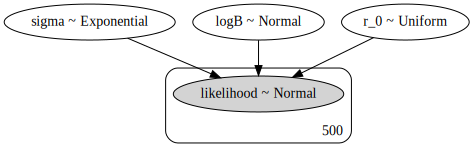

In [10]:
from IPython.display import display
display(pm.model_to_graphviz(mdl_ode))

In [11]:
with mdl_ode:
    traces_ols = pm.sample(1000, tune=500, n_jobs=4)

display(pm.summary(traces_ols))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, r_0, logB]
Sampling 2 chains: 100%|██████████| 3000/3000 [20:15<00:00,  1.20draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logB,-2.270173,0.033802,0.001179,-2.330913,-2.201281,731.341574,1.000483
r_0,10.550092,0.498056,0.016963,9.589909,11.525212,773.728594,1.000927
sigma,2.951605,0.094119,0.002920,2.779479,3.139794,880.924716,0.999673


How have our chains behaved relative to the true values?

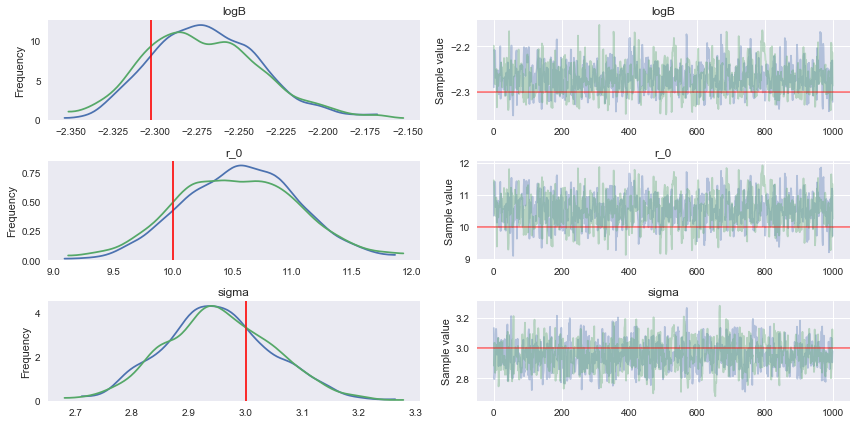

In [12]:
pm.traceplot(traces_ols, lines={'logB': np.log(true_b), 'sigma': true_sigma, 'r_0': true_r0},
             combined=False);

Our posterior KDEs look like:

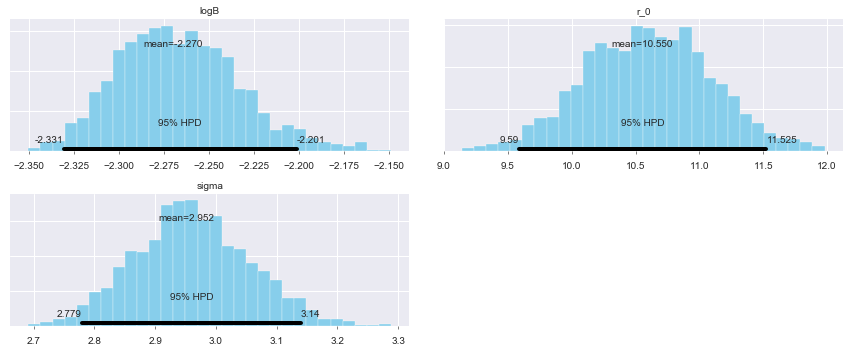

In [45]:
pm.plots.plot_posterior(traces_ols);

# Real data

Okay, so it works in principle. What about for galaxy builder classifications?

In [14]:
from gzbuilderspirals.oo import Arm
a = Arm.load('lib/spiral_arms/20902001-0.pickle')
arm = Arm(a.get_parent(), a.arms)
arm

In [28]:
print('Log spiral pitch angle: {:.2f} ± {:.3f}˚'.format(arm.pa, arm.sigma_pa))

Log spiral pitch angle: 30.65 ± 0.489˚


In [15]:
t_gal = arm.t[np.argsort(arm.t)]
R_gal = arm.R[np.argsort(arm.t)] * 512
R_logsp = arm.logsp_model.predict(t_gal.reshape(-1, 1)) * 512
if arm.chirality < 1:
    t_gal = np.flip(-t_gal)
    R_gal = np.flip(R_gal)
    R_logsp = np.flip(R_logsp)

In [22]:
def f_gal(p):
    # p = (b, r0, dt)
    y = odeint(dydt, p[1], t_gal, args=(p[0],))[:, 0]
    return np.abs((y - R_gal) * arm.point_weights).sum()

%time res = optimize.minimize(f_gal, (0.1, 20))
guess_b, guess_r0 = res['x']
y_guess = odeint(dydt, guess_r0, t_gal, args=(guess_b,))[:, 0]
guess_sigma = (R_gal - y_guess).std()

CPU times: user 229 ms, sys: 9.4 ms, total: 239 ms
Wall time: 232 ms


Swing amplified spiral:   0.9159
Log spiral:               0.9641


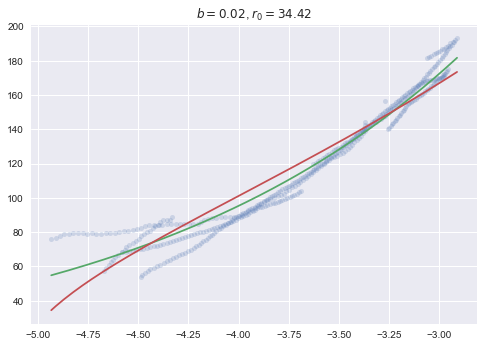

In [17]:
plt.plot(t_gal, R_gal, '.', markersize=10, alpha=0.2)
plt.plot(t_gal, R_logsp)
plt.plot(t_gal, y_guess)
plt.title(r'$b = {:.2f}$, $r_0 = {:.2f}$'.format(guess_b, guess_r0));
# plt.yscale('log')
print('{:<25} {:.4f}'.format('Swing amplified spiral:', r2_score(R_gal, y_guess)))
print('{:<25} {:.4f}'.format('Log spiral:', r2_score(R_gal, R_logsp)))

In [24]:
with pm.Model() as mdl_ode_gal:
    logB = pm.Normal('logB', mu=0, sd=20, testval=np.log(guess_b))
    B = tt.exp(logB)
    r_0 = pm.Uniform('r_0', lower=0, upper=100, testval=guess_r0)
    sigma = pm.Exponential('sigma', lam=0.05, testval=guess_sigma)
    
    y_est, updates = theano.scan(
        fn=theano_rk4,
        sequences=[
            {'input': tt.as_tensor(t_gal), 'taps': [0, -1]}
        ],
        outputs_info=r_0,
        non_sequences=[
            B,
        ]
    )

    y_est = tt.concatenate([[r_0], y_est])
    likelihood = pm.Normal('likelihood', mu=y_est, sd=sigma, observed=R_gal)

with mdl_ode_gal:
    traces_ols_gal = pm.sample(1000, tune=500, n_jobs=4)

df_gal = pm.summary(traces_ols_gal)
display(df_gal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, r_0, logB]
Sampling 2 chains: 100%|██████████| 3000/3000 [10:35<00:00,  3.16draws/s]
The acceptance probability does not match the target. It is 0.899425894002352, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logB,-4.107055,0.014492,0.000445,-4.133189,-4.075722,873.679393,1.000057
r_0,38.078089,2.035990,0.063680,34.427331,42.482250,882.354595,1.000630
sigma,10.742110,0.344170,0.012446,10.049171,11.387054,791.604328,0.999566


In [25]:
df_gal = pm.summary(traces_ols_gal)

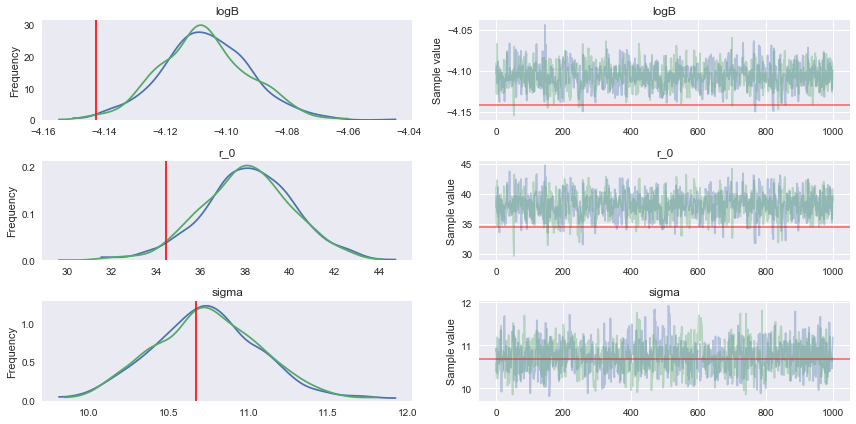

In [26]:
pm.traceplot(traces_ols_gal, lines={'logB': np.log(guess_b), 'sigma': guess_sigma, 'r_0': guess_r0},
             combined=False);

Swing amplified spiral:   0.9159
Log spiral:               0.9641


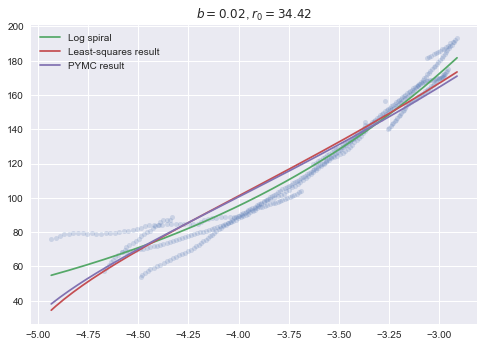

In [27]:
y_guess_mc = odeint(dydt, df_gal['mean'].loc['r_0'], t_gal, args=(np.exp(df_gal['mean'].loc['logB']),))[:, 0]

plt.plot(t_gal, R_gal, '.', markersize=10, alpha=0.2)
plt.plot(t_gal, R_logsp, label='Log spiral')
plt.plot(t_gal, y_guess, label='Least-squares result')
plt.plot(t_gal, y_guess_mc, label='PYMC result')
plt.title(r'$b = {:.2f}$, $r_0 = {:.2f}$'.format(guess_b, guess_r0));
plt.legend();
# plt.yscale('log')
print('{:<25} {:.4f}'.format('Swing amplified spiral:', r2_score(R_gal, y_guess)))
print('{:<25} {:.4f}'.format('Log spiral:', r2_score(R_gal, R_logsp)))

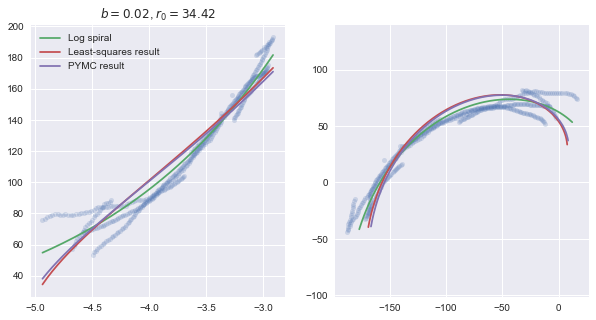

In [52]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(t_gal, R_gal, '.', markersize=10, alpha=0.2)
plt.plot(t_gal, R_logsp, label='Log spiral')
plt.plot(t_gal, y_guess, label='Least-squares result')
plt.plot(t_gal, y_guess_mc, label='PYMC result')
plt.title(r'$b = {:.2f}$, $r_0 = {:.2f}$'.format(guess_b, guess_r0));
plt.legend()

plt.subplot(122)
plt.plot(*xy_from_r_theta(R_gal, t_gal), '.', markersize=10, alpha=0.2)
plt.plot(*xy_from_r_theta(R_logsp, t_gal), label='Log spiral')
plt.plot(*xy_from_r_theta(y_guess, t_gal), label='Least-squares result')
plt.plot(*xy_from_r_theta(y_guess_mc, t_gal), label='PYMC result')
plt.axis('equal');

What do the r2 scores of the different models look like?

In [53]:
print('{:<25} {:.4f}'.format('Swing amplified spiral:', r2_score(R_gal, y_guess)))
print('{:<25} {:.4f}'.format('Log spiral:', r2_score(R_gal, R_logsp)))

Swing amplified spiral:   0.9159
Log spiral:               0.9641
